In [ ]:

from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [ ]:
ham = Hamiltonian("one_d_wire")
gf = GreensFunction(ham)


energy = np.linspace(-6,6, 200)

dos = [None] * 200

for ide, e in enumerate(energy):
    dos[ide] = np.sum(gf.compute_density_of_states(E=e, self_energy_method="sancho_rubio"))
plt.scatter(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

for ide, e in enumerate(energy):
    dos[ide] = gf.compute_transmission(E=e)
plt.scatter(dos, energy)
plt.ylabel('Energy')
plt.xlabel('Tranmission')
plt.title('Transmission vs energy')

plt.show()

In [ ]:

hamiltonian = Hamiltonian("qpc")
hamiltonian.Vg = 0.0
gf = GreensFunction(hamiltonian)
H00, H01, H10 = hamiltonian.get_H00_H01_H10()

print(H00.toarray())
print(H01.toarray())

for ide, e in enumerate(energy):
    dos[ide] = np.sum(gf.compute_density_of_states(E=e, self_energy_method="sancho_rubio"))
plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

In [ ]:
import scipy.sparse as sp
from utils import smart_inverse

E = 100+1e-6j
H = ham.create_hamiltonian(blocks=False)
n = H.shape[0]

sigma_L = gf.lead_self_energy.self_energy("left", E, "sancho_rubio")
sigma_R = gf.lead_self_energy.self_energy("right", E, "sancho_rubio")


block_size = sigma_L.shape[0]

Sigma_L_full = sp.lil_matrix((n, n), dtype=complex)
Sigma_R_full = sp.lil_matrix((n, n), dtype=complex)
Sigma_L_full[:block_size, :block_size] = sigma_L
Sigma_R_full[-block_size:, -block_size:] = sigma_R
Sigma_L_full = Sigma_L_full.tocsc()
Sigma_R_full = Sigma_R_full.tocsc()

H_eff = H + Sigma_L_full + Sigma_R_full
A = E * sp.identity(n, dtype=complex, format='csc') - H_eff

# Use smart_inverse for efficient computation
G_R = smart_inverse(A)

if not sp.issparse(G_R):
    G_R = sp.csc_matrix(G_R)

Gamma_L = 1j * (Sigma_L_full - Sigma_L_full.conj().T)
Gamma_R = 1j * (Sigma_R_full - Sigma_R_full.conj().T)
print(Gamma_L.toarray())

T=(Gamma_L @ G_R @ Gamma_R @ G_R.conj().T)
print(T.toarray())



In [ ]:
A,B,C=gf.compute_central_greens_function(0, compute_lesser=False)
print(A)

In [ ]:
# Debug: Compare device boundary blocks and lead Hamiltonian
ham = Hamiltonian("qpc")
ham.W = 30
ham.L = 100
ham.t = 1.0
ham.o = 0.0
ham.Vg = 1.0

H = ham.create_hamiltonian(blocks=False).toarray()
print("Device first row block:")
print(H[:ham.W, :ham.W])
print("Device last row block:")
print(H[-ham.W:, -ham.W:])

H00, H01, H10 = ham.get_H00_H01_H10()
print("Lead H00:")
print(H00.toarray())
print("Lead H01:")
print(H01.toarray())

In [ ]:
# Sweep Fermi energy and plot transmission for QPC
ham = Hamiltonian("qpc")

ham.W = 10
ham.L = 30
ham.t = 1.0
ham.o = 0.0
ham.Vg = .1  # Moderate barrier

gf = GreensFunction(ham)

energies = np.linspace(-2, 2, 100)
transmission = []
for E in energies:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energies, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [ ]:
import numpy as np
import os
import sys
import heapq
import scipy.sparse as sp


class Atom:
    def __init__(self, x, y, z, precision=10):
        # 1. This method is called whenever a NEW Atom is created.
        #    It immediately rounds the coordinates and stores them.
        self.x = round(x, precision)
        self.y = round(y, precision)
        self.z = round(z, precision)


    def add(self, delta):
        # 2. A calculation is performed, which might result in a float with
        #    many decimal places (e.g., 0.866025... + 1.0 = 1.866025...).
        new_x = self.x + delta[0]
        new_y = self.y + delta[1]
        new_z = self.z + delta[2]

        # 3. We create a NEW Atom object. Crucially, this calls the __init__
        #    method above, which cleans and rounds the coordinates instantly.
        return Atom(new_x, new_y, new_z)

    def __eq__(self, other):
        # 4. Because all Atom objects are guaranteed to have rounded coordinates,
        #    this simple check is reliable.
        return isinstance(other, Atom) and self.pos() == other.pos()

    def __hash__(self):
        # 5. The hash is also based on the clean, rounded coordinates,
        #    ensuring that if a == b, then hash(a) == hash(b).
        return hash(self.pos())

    def pos(self):
        """Return the position as a tuple for hashing and comparison."""
        return (self.x, self.y, self.z)

    def add(self, delta):
        # This method doesn't need rounding, as the new Atom's __init__ will handle it.
        return Atom(self.x + delta[0], self.y + delta[1], self.z + delta[2])

    def __lt__(self, other):
        return self.pos() < other.pos()
        
    def __repr__(self):
        return f"Atom({self.x}, {self.y}, {self.z})"
    
class GrapeheneZigZagCell:
    a = 1
    sin60 = np.sqrt(3) / 2
    cos60 = 1/2 
    base = [Atom(sin60,0,0), Atom(0, cos60, 0), Atom(0,1.5,0), Atom(sin60, 2,0)]
    
    deltas = {
        0 : [(0,1,0), (-sin60, -cos60, 0),(sin60, -cos60, 0)],
        1 : [(0,-1,0), (-sin60, cos60, 0),(sin60, cos60, 0)]
    }
    def __init__(self, num_layers_x, num_layers_y):
        self.num_layers_y = num_layers_y
        self.num_layers_x = num_layers_x
        
        self.max_X = self.sin60 + num_layers_x *2*self.sin60
        self.max_Y = 3 *num_layers_y - 1
         
        
        self.layer = self.create_first_layer()
        self.structure = self.create_full_structure()
        
        self.sublattice = {}
        
        for idx, atom in enumerate(self.structure):
            self.sublattice[atom] = (idx+1)%2
        
        self.neighbors, self.dangling = self.neighbors_and_dangling()
    def create_first_layer(self):
        layer = []
        for y in range(self.num_layers_y):
            delta = (0,3*y, 0)
            new_atoms = map(lambda x: x.add(delta), GrapeheneZigZagCell.base)
            layer.extend(new_atoms)
        
        return layer
    
    def create_full_structure(self):
        structure = []
        for x in range(self.num_layers_x):
            delta = (self.sin60 * x*2, 0,0)
            new_atoms = map(lambda x: x.add(delta), self.layer)
            structure.extend(new_atoms)
        
        return structure
    
    def check_in_y_direction(self, atom):
        if (atom.y < 0 or atom.y > self.max_Y):
            return False
        return True
    def check_in_x_direction(self, atom):
        if (atom.x < 0 or atom.x > self.max_X):
            return False
        return True
    def directionalCosine(delta):
        dx,dy,dz = delta
        norm = np.sqrt(dx**2 + dy**2 + dz**2)
        
        if norm != 0:
            l = dx / norm
            m = dy / norm
            n = dz / norm
        return l, m, n
    def get_sublattice(self, atom: Atom):
        """return 0 or 1"""
        return self.sublattice[atom]
    def neighbors_and_dangling(self):
        neighbors = {}
        dangling_bonds = {}
        atom_set = set(self.structure)
        
        for atom in self.structure:
            neighbors[atom] = []
            dangling_bonds[atom] = []
            deltas = GrapeheneZigZagCell.deltas[self.get_sublattice(atom)]
            for delta in deltas:
                neighbor = atom.add(delta)
                
                if (not self.check_in_y_direction(neighbor)):
                    l, m, n = GrapeheneZigZagCell.directionalCosine(delta)
                    dangling_bonds[atom].append((neighbor, delta, l, m, n))  
                elif (self.check_in_y_direction(neighbor) and self.check_in_x_direction(neighbor)):

                    # in the structure 
                    l, m, n = GrapeheneZigZagCell.directionalCosine(delta)
                    neighbors[atom].append((neighbor, delta, l, m, n))   
                # ignore x 
        
        return neighbors, dangling_bonds
    
    def build_hamiltonian(self, t=-1.0, onsite_potential=0.0):
        """
        Builds the full tight-binding Hamiltonian for the nanoribbon structure.

        Args:
            t (float): The nearest-neighbor hopping parameter.
            onsite_potential (float): The on-site energy for all atoms.

        Returns:
            scipy.sparse.csr_matrix: The full Hamiltonian matrix.
        """
        
        num_atoms_total = len(self.structure)
        num_atoms_layer = len(self.layer)
        
        # Create a mapping from atom object to its index in the full structure list
        atom_to_idx = {atom: i for i, atom in enumerate(self.structure)}
        
        # --- 1. Build the Onsite Block (H0) ---
        # Describes connections within one layer (unit cell)
        H0 = np.zeros((num_atoms_layer, num_atoms_layer))
        
        # Create a mapping for just the first layer
        layer_atom_to_idx = {atom: i for i, atom in enumerate(self.layer)}
        
        for i, atom in enumerate(self.layer):
            H0[i, i] = onsite_potential
            # Find neighbors that are also in the first layer
            for neighbor, delta, l, m, n in self.neighbors[atom]:
                if neighbor in layer_atom_to_idx:
                    j = layer_atom_to_idx[neighbor]
                    H0[i, j] = t

        # --- 2. Build the Interaction Block (H1) ---
        # Describes connections between layer 0 and layer 1
        H1 = np.zeros((num_atoms_layer, num_atoms_layer))
        
        # Find neighbors of atoms in layer 0 that are in layer 1
        layer_1_atoms = set(self.structure[num_atoms_layer : 2 * num_atoms_layer])

        for i, atom_in_layer0 in enumerate(self.layer):
            for neighbor, delta, l, m, n in self.neighbors[atom_in_layer0]:
                
                if neighbor in layer_1_atoms:
                    print(neighbor)
                    
                    # Find the corresponding atom in layer 0 by shifting it back
                    # This assumes your structure is perfectly periodic
                    shifted_neighbor_pos = (neighbor.x - (self.sin60 * 2), neighbor.y, neighbor.z)
                    
                    # You need to handle potential floating point issues here
                    # A better way would be to create a robust mapping
                    for atom_in_l0, idx in layer_atom_to_idx.items():
                        if np.allclose(atom_in_l0.pos(), shifted_neighbor_pos, atol=1e-5):
                            j = idx
                            H1[i, j] = t
                            break

        # --- 3. Assemble the Full Hamiltonian using sparse matrices ---
        # This is much more memory-efficient than using numpy arrays for large systems
        
        # Create H0 and H1 as sparse matrices
        H0_sparse = sp.csr_matrix(H0)
        H1_sparse = sp.csr_matrix(H1)
        
        # Create a list of the diagonal blocks (all H0)
        diagonal_blocks = [H0_sparse] * self.num_layers_x
        off_diagonal_blocks = [H1_sparse] * (self.num_layers_x -1)
        return diagonal_blocks, off_diagonal_blocks

In [ ]:
gz = GrapeheneZigZagCell(6, 1)
structure = gz.structure

gz.neighbors

In [ ]:
diag, offdiag = gz.build_hamiltonian()

In [ ]:
offdiag[0].toarray()

In [ ]:


# --- Plotting Code ---

# Extract x and y coordinates from the list of Atom objects
x_coords = [atom.x for atom in structure]
y_coords = [atom.y for atom in structure]

# Create the plot
plt.figure(figsize=(8, 12))
plt.scatter(x_coords, y_coords, s=150, edgecolors='black', facecolors='skyblue', zorder=5)

# Add text labels to identify each atom's index in the list
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.text(x + 0.05, y + 0.05, str(i), fontsize=9, ha='left', va='bottom', zorder=10)

# Formatting the plot for clarity
plt.title("Plot of Generated Atom Coordinates", fontsize=16)
plt.xlabel("X coordinate", fontsize=12)
plt.ylabel("Y coordinate", fontsize=12)
plt.axis('equal')  # This is CRUCIAL for correctly visualizing geometric structures
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [42]:
ham = Hamiltonian("zigzag")
ham.Nx=20
ham.Ny=5

In [43]:
X,Y = ham.create_hamiltonian(True)

In [44]:
gf = GreensFunction(ham)

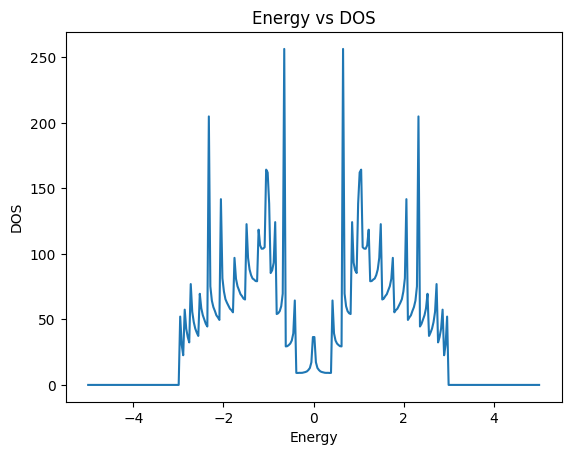

In [45]:

energy = np.linspace(-5,5, 300)
dos = [None] * 300

for ide, e in enumerate(energy):
    dos[ide] = np.sum(gf.compute_density_of_states(E=e, self_energy_method="sancho_rubio"))
plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()



In [1]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
ham = Hamiltonian("zigzag", True)
#ham.Ny = 100



In [2]:
gf = GreensFunction(ham)

In [3]:
dos = gf.calculate_DOS()

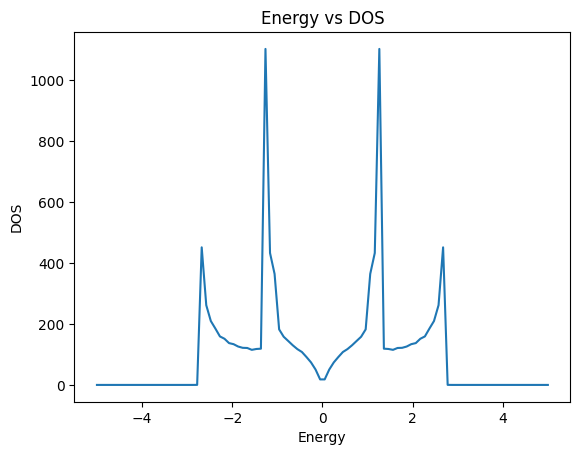

In [4]:
energy_grid = np.linspace(-5,5,100)
plt.plot(energy_grid, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()